# Data Processing

 - Basic panSTARRS data preprocess, then do the following:
1. match and merge WISE catalog 
2. write out lephare input file 
3. write out coord data for masking 


 - Basic 2MASS data preprocess 
1. process 2MASS raw data and write out coord data for masking


Change 'field' name in Set Input Params section and run the whole notebook.

=====================================================================
# Set Input Params

In [1]:
import astropy.io.fits as fits
import astropy.wcs as wcs
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
from sklearn.cluster import DBSCAN
from sklearn.svm import SVC

field = 'elat10'

=====================================================================

# Process PanSTARRS raw data

In [2]:
def panstarrs_prerpocess(field):
    datadir='/Volumes/Drive/ciber/data/PanSTARRScats/'

    df1 = pd.read_csv(datadir + field + '1_raw.csv')
    df2 = pd.read_csv(datadir + field + '2_raw.csv')
    df3 = pd.read_csv(datadir + field + '3_raw.csv')
    df4 = pd.read_csv(datadir + field + '4_raw.csv')
    
    # combine the data
    df_raw = pd.concat([df1,df2,df3,df4]).drop_duplicates(subset = 'ObjID')
    df_raw = df_raw.drop(['ObjID'],axis=1)
    
    # select flag 8 and flag 16 column
    flag_arr = df_raw.qualityFlag
    bin_values = np.flip(2 ** np.arange(11),0)
    flag_bin_arr = np.zeros([len(flag_arr),len(bin_values)],dtype=int)

    for i, flag in enumerate(flag_arr):
        bin_str = "{:011b}".format(flag)
        bin_int = list(map(int,list(bin_str)))
        flag_bin_arr[i,:] = bin_int

    flag_bin_arr8 = flag_bin_arr[:,int(np.where(bin_values==8)[0])]
    flag_bin_arr16 = flag_bin_arr[:,int(np.where(bin_values==16)[0])]

    for i,bin_value in enumerate(bin_values):
            df_raw['flag{}'.format(bin_value)] = flag_bin_arr[:,i]

    df = df_raw[(df_raw.flag8 == 1) | (df_raw.flag16 == 1)].copy()
    
    # set the default value to -99
    df.replace([-999],-99,inplace=True)
    
    # select source having band y magnitude
    # df = df[df.yMeanPSFMag!=-99].copy()
    sp = np.where((df['gMeanPSFMag']!=-99)|(df['rMeanPSFMag']!=-99)|\
                   (df['iMeanPSFMag']!=-99)|(df['zMeanPSFMag']!=-99)|(df['yMeanPSFMag']!=-99))[0]
    df = df.iloc[sp].copy()
    df = df.reset_index(drop=True)
    
    df = df[['ra', 'dec', 'gMeanPSFMag', 'rMeanPSFMag', 'iMeanPSFMag', 'zMeanPSFMag', 'yMeanPSFMag', \
         'gMeanPSFMagErr', 'rMeanPSFMagErr', 'iMeanPSFMagErr', 'zMeanPSFMagErr', 'yMeanPSFMagErr']].copy()
    return df

def panstarrs_add_xy(field, df):
    order = [c for c in df.columns]
    # find the x, y solution with all quad
    for inst in [1,2]:
        hdrdir = '/Users/ytcheng/ciber/doc/20170617_Stacking/maps/astroutputs/inst' + str(inst) + '/'
        xoff = [0,0,512,512]
        yoff = [0,512,0,512]
        for iquad,quad in enumerate(['A','B','C','D']):
            hdulist = fits.open(hdrdir + field + '_' + quad + '_astr.fits')
            wcs_hdr=wcs.WCS(hdulist[('primary',1)].header, hdulist)
            hdulist.close()
            src_coord = SkyCoord(ra=df['ra']*u.degree, dec=df['dec']*u.degree, frame='icrs')

            x_arr, y_arr = wcs_hdr.all_world2pix(df['ra'],df['dec'],0)
            df['x' + quad] = x_arr + xoff[iquad]
            df['y' + quad] = y_arr + yoff[iquad]

        df['meanx'] = (df['xA'] + df['xB'] + df['xC'] + df['xD']) / 4
        df['meany'] = (df['yA'] + df['yB'] + df['yC'] + df['yD']) / 4

        # assign the x, y with the nearest quad solution
        df['x'+str(inst)] = df['xA'].copy()
        df['y'+str(inst)] = df['yA'].copy()
        bound = 511.5
        df.loc[ (df['meanx'] < bound) & (df['meany'] > bound),'x'+str(inst)] = df['xB']
        df.loc[ (df['meanx'] < bound) & (df['meany'] > bound),'y'+str(inst)] = df['yB']
        
        df.loc[ (df['meanx'] > bound) & (df['meany'] < bound),'x'+str(inst)] = df['xC']
        df.loc[ (df['meanx'] > bound) & (df['meany'] < bound),'y'+str(inst)] = df['yC']

        df.loc[ (df['meanx'] > bound) & (df['meany'] > bound),'x'+str(inst)] = df['xD']
        df.loc[ (df['meanx'] > bound) & (df['meany'] > bound),'y'+str(inst)] = df['yD']

    # write x, y to df
    order = order[:2] + ['x1','y1','x2','y2'] + order[2:]
    dfout = df[order].copy()
    
    return dfout

In [3]:
df = panstarrs_prerpocess(field)
df = panstarrs_add_xy(field,df)

NOTE: TM2 is 90 deg rotate, so the x, y coord for two inst is different

In [4]:
df.head()

,ra,dec,x1,y1,x2,y2,gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,yMeanPSFMag,gMeanPSFMagErr,rMeanPSFMagErr,iMeanPSFMagErr,zMeanPSFMagErr,yMeanPSFMagErr
0,189.098640,6.621096,198.594144,-459.466989,-451.689741,841.586021,-99.000000,21.086201,20.579399,20.291901,20.0956,-99.000000,0.059161,0.027954,0.044119,0.016302
1,189.107960,6.624595,198.006218,-454.363981,-446.593944,842.091304,-99.000000,21.528400,20.618799,20.319799,20.0173,-99.000000,0.066563,0.028124,0.064615,0.125194
2,189.109468,6.620616,195.817242,-454.646884,-446.841816,844.272158,-99.000000,-99.000000,21.372999,21.051800,-99.0000,-99.000000,-99.000000,0.055610,0.084080,-99.000000
3,189.158775,6.624031,185.749462,-431.334002,-423.445556,853.920073,-99.000000,-99.000000,-99.000000,-99.000000,19.8151,-99.000000,-99.000000,-99.000000,-99.000000,0.177683
4,189.042482,6.607351,205.514525,-488.429557,-480.666161,835.155001,22.130501,-99.000000,21.811600,-99.000000,-99.0000,0.186253,-99.000000,0.193023,-99.000000,-99.000000


In [5]:
df.describe()

,ra,dec,x1,y1,x2,y2,gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,yMeanPSFMag,gMeanPSFMagErr,rMeanPSFMagErr,iMeanPSFMagErr,zMeanPSFMagErr,yMeanPSFMagErr
count,190846.000000,190846.000000,190846.000000,190846.000000,190846.000000,190846.000000,190846.000000,190846.000000,190846.000000,190846.000000,190846.000000,190846.000000,190846.000000,190846.000000,190846.000000,190846.000000
mean,190.442252,8.033166,527.503556,491.171681,490.711248,498.202372,-43.804783,-22.681956,5.252626,-15.870213,-50.000719,-53.711766,-36.207009,-13.242631,-30.243115,-58.117914
std,0.832878,0.846092,440.062150,423.434223,422.250653,438.856886,59.895598,57.652514,40.381708,54.888274,58.294623,49.360141,47.740272,33.812823,45.665734,48.781050
min,189.000006,6.600004,-472.968713,-507.659429,-499.929930,-507.259088,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000
25%,189.727224,7.295862,185.565077,167.495723,165.501992,154.032942,-99.000000,-99.000000,19.712099,-99.000000,-99.000000,-99.000000,-99.000000,0.015293,-99.000000,-99.000000
50%,190.426255,8.027838,531.663980,496.806388,495.742650,494.682447,-99.000000,20.381250,21.165600,20.201401,-99.000000,-99.000000,0.026950,0.050111,0.032156,-99.000000
75%,191.158664,8.770371,870.720623,815.396523,816.329374,842.544748,21.668301,21.509001,21.659599,21.071899,19.630175,0.051955,0.083098,0.129338,0.091933,0.043609
max,191.899995,9.499998,1540.804336,1502.950827,1493.047589,1490.306241,26.892000,26.940001,27.320700,23.033300,22.816500,0.499496,0.498855,0.499909,0.498425,0.499906


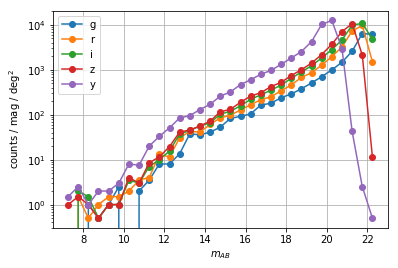

In [6]:
# plot histogram

binedges = np.arange(7,23,0.5)
bins = (binedges[:-1] + binedges[1:])/2
d = df['gMeanPSFMag'][(df['x1'] > -0.5) & (df['y1'] > -0.5) & (df['x1'] < 1023.5) & (df['y1'] < 1023.5)]
shist,_ = np.histogram(d, bins = binedges)
plt.plot(bins,shist / (binedges[1]-binedges[0]) / 4,'o-',label='g')
d = df['rMeanPSFMag'][(df['x1'] > -0.5) & (df['y1'] > -0.5) & (df['x1'] < 1023.5) & (df['y1'] < 1023.5)]
shist,_ = np.histogram(d, bins = binedges)
plt.plot(bins,shist / (binedges[1]-binedges[0]) / 4,'o-',label='r')
d = df['iMeanPSFMag'][(df['x1'] > -0.5) & (df['y1'] > -0.5) & (df['x1'] < 1023.5) & (df['y1'] < 1023.5)]
shist,_ = np.histogram(d, bins = binedges)
plt.plot(bins,shist / (binedges[1]-binedges[0]) / 4,'o-',label='i')
d = df['zMeanPSFMag'][(df['x1'] > -0.5) & (df['y1'] > -0.5) & (df['x1'] < 1023.5) & (df['y1'] < 1023.5)]
shist,_ = np.histogram(d, bins = binedges)
plt.plot(bins,shist / (binedges[1]-binedges[0]) / 4,'o-',label='z')
d = df['yMeanPSFMag'][(df['x1'] > -0.5) & (df['y1'] > -0.5) & (df['x1'] < 1023.5) & (df['y1'] < 1023.5)]
shist,_ = np.histogram(df['yMeanPSFMag'], bins = binedges)
plt.plot(bins,shist / (binedges[1]-binedges[0]) / 4,'o-',label='y')

plt.yscale('log')
plt.xlabel('$m_{AB}$')
plt.ylabel('counts / mag / deg$^2$')
plt.legend()
plt.grid()
plt.savefig('ps_counts.png', dpi = 200)

# match WISE

In [7]:
def wise_preprocess(field):
    wisedir='/Volumes/Drive/ciber/data/wisecats/'

    f = open(wisedir + field + '.tbl')
    wdfname = f.readlines()[14].strip().replace(" ", "").split('|')[1:-1]
    f.close()
    wsdf = pd.read_csv(wisedir + field + '.tbl', sep = '\s+', skiprows = 18,\
                       names = wdfname, low_memory = False)
    wsdf = wsdf.drop(wdfname[-2:],axis=1)

    # replace null with -99
    wsdf[list(wsdf)[2:]] = wsdf[list(wsdf)[2:]].apply(pd.to_numeric, errors = 'coerce')
    wsdf = wsdf.replace(np.nan,-99)

    # convert mag_vega to mag_AB 
    # http://wise2.ipac.caltech.edu/docs/release/prelim/expsup/sec4_3g.html (table 5)
    wsdf['w1mpro'] = wsdf['w1mpro'] + 2.683
    wsdf['w2mpro'] = wsdf['w1mpro'] + 3.319
    wsdf['w3mpro'] = wsdf['w1mpro'] + 5.242
    wsdf['w4mpro'] = wsdf['w1mpro'] + 6.604
    
    return wsdf

def match_panstarrs_wise(df, wsdf):
    coordws = SkyCoord(ra=wsdf['ra']*u.degree, dec=wsdf['dec']*u.degree,frame='icrs')
    coordps = SkyCoord(ra=df['ra']*u.degree, dec=df['dec']*u.degree, frame='icrs')

    idx, d2d,_ = match_coordinates_sky(coordps, coordws)
    
    wsdf_matched = wsdf[list(wsdf)[2:-7]].iloc[idx].reset_index(drop=True)
    df = pd.concat([df, wsdf_matched],axis = 1)
    df['dmatch_arcsec']=d2d.arcsec

    return df

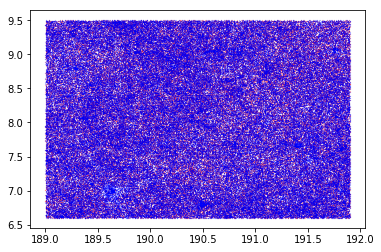

In [8]:
wsdf = wise_preprocess(field)
# check the coverage (make sure WISE(red) cover PanSTARRS(blue) field)
plt.plot(figsize=(4,4))
plt.plot(wsdf['ra'],wsdf['dec'],'ro', linestyle='', ms=0.1)
plt.plot(df['ra'],df['dec'],'bo', linestyle='', ms=0.1)

In [9]:
df = match_panstarrs_wise(df, wsdf)

# write lePHARE input file (PanSTARS + WISE / PanSTARRS only)

In [10]:
def write_lephare_in(field, df):
    # PS + WISE
    df_lph = df[['gMeanPSFMag','gMeanPSFMagErr','rMeanPSFMag','rMeanPSFMagErr',\
                 'iMeanPSFMag','iMeanPSFMagErr','zMeanPSFMag','zMeanPSFMagErr',\
                 'yMeanPSFMag','yMeanPSFMagErr', 'w1mpro', 'w1sigmpro', 'w2mpro', \
                 'w2sigmpro', 'w3mpro', 'w3sigmpro', 'w4mpro', 'w4sigmpro']].copy()

    df_lph['w1sigmpro'].replace([-99], max(df_lph['w1sigmpro']),inplace=True)
    df_lph['w2sigmpro'].replace([-99], max(df_lph['w2sigmpro']),inplace=True)
    df_lph['w3sigmpro'].replace([-99], max(df_lph['w3sigmpro']),inplace=True)
    df_lph['w4sigmpro'].replace([-99], max(df_lph['w4sigmpro']),inplace=True)
    df_lph['Imag'] = np.ones(len(df_lph))*-99
    df_lph['Imag_err'] = np.ones(len(df_lph))*-99
    df_lph['Hmag'] = np.ones(len(df_lph))*-99
    df_lph['Hmag_err'] = np.ones(len(df_lph))*-99

    df_lph.index += 1
    savedir = '~/ciber/lephare/lephare_dev/panstarrs/'
    df_lph.to_csv(savedir + field +'_WISE.in',sep=' ',header=False, float_format='%.3e')
    
    # PS only
    df_lph1 = df_lph[['gMeanPSFMag','gMeanPSFMagErr','rMeanPSFMag','rMeanPSFMagErr',\
                 'iMeanPSFMag','iMeanPSFMagErr','zMeanPSFMag','zMeanPSFMagErr',\
                 'yMeanPSFMag','yMeanPSFMagErr','Imag','Imag_err','Hmag','Hmag_err']].copy()
    df_lph1.to_csv(savedir + field +'.in',sep=' ',header=False, float_format='%.3e')
    
    return

In [11]:
write_lephare_in(field ,df)

# match SDSS

In [12]:
def SDSS_preprocess(field):
    sdssdir='/Volumes/Drive/ciber/data/SDSScats/'
    f = open(sdssdir + field + '.csv')
    wdfname = f.readlines()[1].strip().split(',')
    f.close()
    sdssdf = pd.read_csv(sdssdir + field + '.csv', skiprows = 2,\
                       names = wdfname, low_memory = False) 
    
    return sdssdf

def match_panstarrs_SDSS(df, sdssdf):
    coordsd = SkyCoord(ra=sdssdf['ra']*u.degree, dec=sdssdf['dec']*u.degree,frame='icrs')
    coordps = SkyCoord(ra=df['ra']*u.degree, dec=df['dec']*u.degree, frame='icrs')

    idx, d2d,_ =  match_coordinates_sky(coordps, coordsd)
    
    sddf_matched = sdssdf[list(sdssdf)[2:10]].iloc[idx].reset_index(drop=True)
    df = pd.concat([df, sddf_matched],axis = 1)
    df['dmatch_arcsec_sdss']=d2d.arcsec

    return df

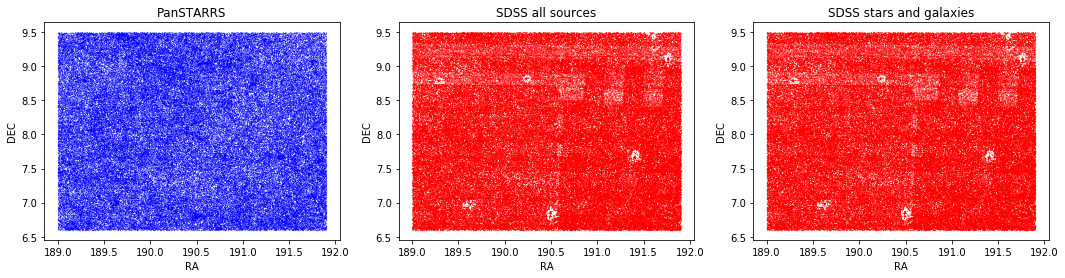

In [13]:
#
sdssdf = SDSS_preprocess(field)

fig, ax = plt.subplots(1,3,figsize=(18,4))
ax[0].plot(df['ra'],df['dec'],'bo', linestyle='', ms=0.1)
ax[0].set_xlabel('RA')
ax[0].set_ylabel('DEC')
ax[0].set_title('PanSTARRS')
ax[1].plot(sdssdf['ra'],sdssdf['dec'],'ro', linestyle='', ms=0.1)
ax[1].set_xlabel('RA')
ax[1].set_ylabel('DEC')
ax[1].set_title('SDSS all sources')
ax[1].set_xlim(ax[0].get_xlim())
ax[1].set_ylim(ax[0].get_ylim())

sdssdf = sdssdf.loc[((sdssdf['type'] == 3) | (sdssdf['type'] == 6))]
ax[2].plot(sdssdf['ra'],sdssdf['dec'],'ro', linestyle='', ms=0.1)
ax[2].set_xlabel('RA')
ax[2].set_ylabel('DEC')
ax[2].set_title('SDSS stars and galaxies')
ax[2].set_xlim(ax[0].get_xlim())
ax[2].set_ylim(ax[0].get_ylim())
fig.savefig('SDSS_map_' + field, dpi = 256, bbox_inches='tight')

In [14]:
df = match_panstarrs_SDSS(df, sdssdf)

# Color-Color diamgram Star/Gal classification

In [15]:
def plot_PS_wise_dmatch(df):
    fig, ax = plt.subplots(1,2,figsize=(12,4))
    
    logdmatch_arr = np.log10(np.array(df['dmatch_arcsec']))
    binedges = np.arange(-3,2.1,0.25)
    bins = (binedges[:-1] + binedges[1:])/2

    hist,_ = np.histogram(logdmatch_arr, bins = binedges)
    ax[0].plot(bins,hist / (binedges[1:]-binedges[:-1]),'o-')
    ax[0].set_xlabel('match distance [arcsec]', fontsize=20)
    ax[0].set_ylabel('count', fontsize=20)
    ax[0].axvline(0.35, c='k')
    
    ax[1].plot(logdmatch_arr, df['yMeanPSFMag'], 'o', ms=0.1)
    ax[1].set_xlabel('match distance [arcsec]', fontsize=20)
    ax[1].set_ylabel('PanSTARRS y ABmag', fontsize=20)
    ax[1].axvline(0.35, c='k')
    
    #fig.savefig(savedir + field + '_dmatch', dpi = 256, bbox_inches='tight')
    return

def plot_PS_SDSS_dmatch(df):
    fig, ax = plt.subplots(1,2,figsize=(12,4))
    
    logdmatch_arr = np.log10(np.array(df['dmatch_arcsec_sdss']))
    binedges = np.arange(-3,2.1,0.25)
    bins = (binedges[:-1] + binedges[1:])/2

    hist,_ = np.histogram(logdmatch_arr, bins = binedges)
    ax[0].plot(bins,hist / (binedges[1:]-binedges[:-1]),'o-')
    ax[0].set_xlabel('match distance [arcsec]', fontsize=20)
    ax[0].set_ylabel('count', fontsize=20)
    ax[0].axvline(0.35, c='k')
    
    ax[1].plot(logdmatch_arr, df['yMeanPSFMag'], 'o', ms=0.1)
    ax[1].set_xlabel('match distance [arcsec]', fontsize=20)
    ax[1].set_ylabel('PanSTARRS y ABmag', fontsize=20)
    ax[1].axvline(0.35, c='k')
    
    fig.savefig(field + '_dmatch_SDSS', dpi = 256, bbox_inches='tight')
    return

def color_color_classification(df):
    fig, ax = plt.subplots(1,3,figsize=(16,4))
    
    b1_arr = np.array(df['rMeanPSFMag'])
    b2_arr = np.array(df['zMeanPSFMag'])
    w_arr = np.array(df['w2mpro'])
    dmatch_arr = np.array(df['dmatch_arcsec'])
    dbcls_arr=np.ones(len(b1_arr)) * -99
    
    idx = np.where((b1_arr>-98) & (b2_arr>-98) & (w_arr>-98) & (dmatch_arr<0.35))[0]
    c1_arr = b1_arr[idx] - b2_arr[idx]
    c2_arr = b2_arr[idx] - w_arr[idx]
    ax[0].plot(c1_arr, c2_arr, '.', ms=0.3)
    ax[0].set_xlabel('r-z', fontsize=20)
    ax[0].set_ylabel('z-w2(4.6 um)', fontsize=20)  
    ax[0].set_xlim([-1,4])
    ax[0].set_ylim([-6,0.5])

    # DBSCAN clustering
    X = np.array([c1_arr,c2_arr]).T
    db = DBSCAN(eps=0.08, min_samples=20).fit(X)
    Y0 = np.array(db.labels_)
    print('DBSCAN find {} classes'.format(len(np.unique(Y0))-1))
    
    # assign Y=0 to stars (smaller c2_arr) and Y=1 to gals (larger c2_arr)
    Y = Y0.copy()
    # 0 - gal, 1 - stars
    if np.mean(c2_arr[Y0==0]) >= np.mean(c2_arr[Y0==1]):
        Y[Y0==0] = 1
        Y[Y0==1] = 0
    # 0 - stars, 1 - gals
    else:
        Y[Y0==0] = 0
        Y[Y0==1] = 1

    ax[1].plot(c1_arr[Y==0],c2_arr[Y==0],'r.',ms=0.3)
    ax[1].plot(c1_arr[Y==1],c2_arr[Y==1],'g.',ms=0.3)
    ax[1].plot(c1_arr[Y==-1],c2_arr[Y==-1],'k.',ms=0.3)
    ax[1].set_xlim([-1,4])
    ax[1].set_ylim([-6,0.5])
    ax[1].set_title('DBSCAN')
    ax[1].set_xlabel('r-z', fontsize=20)
    ax[1].set_ylabel('z-w2(4.6 um)', fontsize=20)
    
    # SVM 
    clf = SVC()
    clf.fit(X[(Y==0) | (Y==1),:], Y[(Y==0) | (Y==1)])
    Ysvm = clf.predict(X)
    ax[2].plot(c1_arr[Ysvm==0],c2_arr[Ysvm==0],'r.',ms=0.5)
    ax[2].plot(c1_arr[Ysvm==1],c2_arr[Ysvm==1],'g.',ms=0.5)
    ax[2].set_xlim([-1,4])
    ax[2].set_ylim([-6,0.5])
    ax[2].set_title('SVM')
    ax[2].set_xlabel('r-z', fontsize=20)
    ax[2].set_ylabel('z-w2(4.6 um)', fontsize=20)
    
    # write classification to df
    cls_arr=np.zeros(len(Y))
    cls_arr[Ysvm==0] = -1 # stars
    cls_arr[Ysvm==1] = 1 # gals

    dbcls_arr[idx] = cls_arr
    df['dbscanClass'] = dbcls_arr
    
    #fig.savefig(savedir + field + '_MLclass', dpi = 256, bbox_inches='tight')
    return df

def sdss_check_classification(df):
    fig, ax = plt.subplots(1,2,figsize=(12,4))
    
    b1_arr = np.array(df['rMeanPSFMag'])
    b2_arr = np.array(df['zMeanPSFMag'])
    w_arr = np.array(df['w2mpro'])
    dmatch_arr = np.array(df['dmatch_arcsec_sdss'])
    cls_arr = np.array(df['dbscanClass'])
    type_arr = np.array(df['type'])
    
    idx = np.where((b1_arr>-98) & (b2_arr>-98) & (w_arr>-98) & (dmatch_arr<0.35) & (cls_arr != -99))[0]
    c1_arr = b1_arr[idx] - b2_arr[idx]
    c2_arr = b2_arr[idx] - w_arr[idx]
    cls_arr = cls_arr[idx]
    type_arr = type_arr[idx]
    ax[0].plot(c1_arr[cls_arr==-1],c2_arr[cls_arr==-1],'r.',ms=0.3, label='stars')
    ax[0].plot(c1_arr[cls_arr==1],c2_arr[cls_arr==1],'g.',ms=0.3, label='galaxies')
    ax[0].set_xlim([-1,4])
    ax[0].set_ylim([-6,0.5])
    ax[0].set_title('DBSCAN + SVM')
    ax[0].set_xlabel('r-z', fontsize=20)
    ax[0].set_ylabel('z-w2(4.6 um)', fontsize=20)
    ax[0].legend(loc=0)

    ax[1].plot(c1_arr[type_arr==6],c2_arr[type_arr==6],'r.',ms=0.3)
    ax[1].plot(c1_arr[type_arr==3],c2_arr[type_arr==3],'g.',ms=0.3)
    ax[1].set_xlim([-1,4])
    ax[1].set_ylim([-6,0.5])
    ax[1].set_title('SDSS')
    ax[1].set_xlabel('r-z', fontsize=20)
    ax[1].set_ylabel('z-w2(4.6 um)', fontsize=20)
    
    misclass_s = sum((type_arr==6) & (cls_arr==1)) / sum(cls_arr==1)
    misclass_g = sum((type_arr==3) & (cls_arr==-1)) / sum(cls_arr==-1)
    ax[1].text(1,0,'%.2f %%  stars misclassified as gals'%(misclass_s*100))
    ax[1].text(1,-0.4,'%.2f %%  gals misclassified as stars'%(misclass_g*100))
    
    # write classification to df
    
    sdcls_arr=np.ones(len(df)) * -99
    z_arr = np.ones(len(df)) * -99
    zErr_arr = np.ones(len(df)) * -99

    idx = np.where(df['dmatch_arcsec_sdss']<0.35)[0]
    type_arr = np.array(df['type'].copy())[idx]
    photz_arr = np.array(df['Photz'].copy())[idx]
    photzErr_arr = np.array(df['PhotzErr'].copy())[idx]
    photz_arr[np.isnan(photz_arr)] = -99
    photz_arr[photz_arr < 0] = -99
    photzErr_arr[np.isnan(photzErr_arr)] = -99
    photzErr_arr[photz_arr < 0] = -99

    sdcls_arr[idx] = type_arr
    type_arr[type_arr==3] = 1
    type_arr[type_arr==6] = -1
    z_arr[idx] = photz_arr
    zErr_arr[idx] = photzErr_arr
    df['Photz'] = z_arr
    df['PhotzErr'] = zErr_arr
    df['sdssClass'] = sdcls_arr

    fig.savefig('SDSSclass_' + field, dpi = 256, bbox_inches='tight')
    return df

DBSCAN find 3 classes


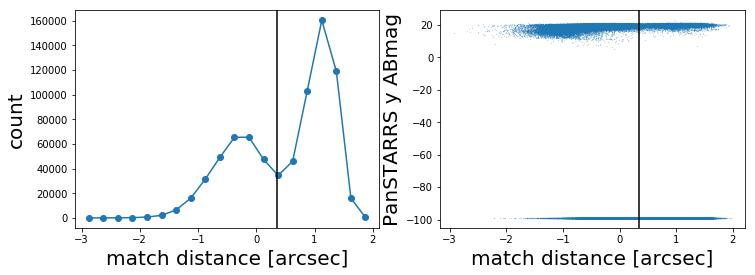

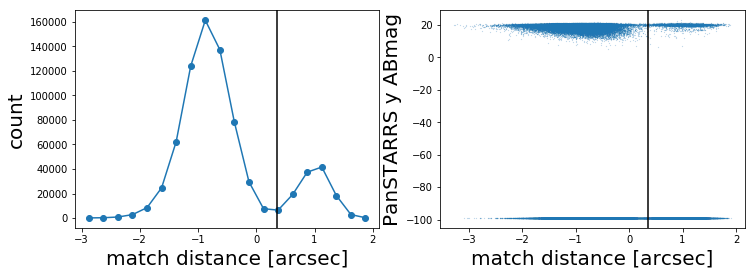

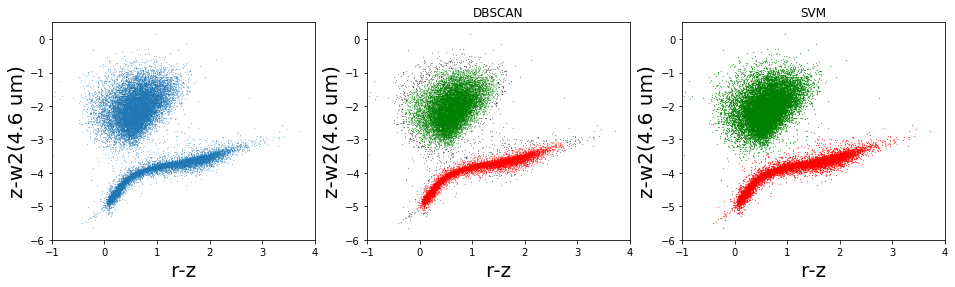

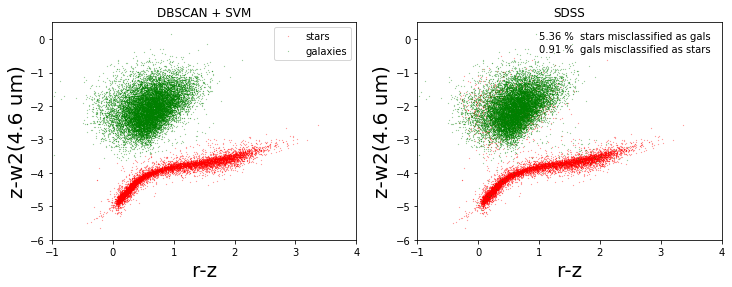

In [16]:
plot_PS_wise_dmatch(df)
plot_PS_SDSS_dmatch(df)
df = color_color_classification(df)
df = sdss_check_classification(df)

# extrapolate the CIBER I, H band

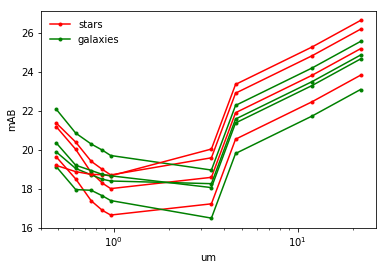

In [17]:
# plot a few stars or galaxy spectrum

stridx = df.index[(df['gMeanPSFMag'] !=-99) & (df['rMeanPSFMag'] !=-99) & \
        (df['iMeanPSFMag'] !=-99) & (df['zMeanPSFMag'] !=-99) & \
        (df['yMeanPSFMag'] !=-99) & (df['dbscanClass'] ==-1)].tolist()
galidx = df.index[(df['gMeanPSFMag'] !=-99) & (df['rMeanPSFMag'] !=-99) & \
        (df['iMeanPSFMag'] !=-99) & (df['zMeanPSFMag'] !=-99) & \
        (df['yMeanPSFMag'] !=-99) & (df['dbscanClass'] ==1)].tolist()


freq = [0.4866, 0.6215, 0.7545, 0.8679, 0.9633,3.4,4.6,12,22]

for idx in np.random.choice(stridx,3):
    mags=df[['gMeanPSFMag', 'rMeanPSFMag', 'iMeanPSFMag', 'zMeanPSFMag', 'yMeanPSFMag',\
         'w1mpro', 'w2mpro', 'w3mpro', 'w4mpro']].iloc[idx]
    plt.plot(freq,np.array(mags),'r.-')
for idx in np.random.choice(galidx,3):
    mags=df[['gMeanPSFMag', 'rMeanPSFMag', 'iMeanPSFMag', 'zMeanPSFMag', 'yMeanPSFMag',\
         'w1mpro', 'w2mpro', 'w3mpro', 'w4mpro']].iloc[idx]
    plt.plot(freq,np.array(mags),'g.-')

mags=df[['gMeanPSFMag', 'rMeanPSFMag', 'iMeanPSFMag', 'zMeanPSFMag', 'yMeanPSFMag',\
     'w1mpro', 'w2mpro', 'w3mpro', 'w4mpro']].iloc[np.random.choice(stridx)]
plt.plot(freq,np.array(mags),'r.-', label = 'stars')
mags=df[['gMeanPSFMag', 'rMeanPSFMag', 'iMeanPSFMag', 'zMeanPSFMag', 'yMeanPSFMag',\
     'w1mpro', 'w2mpro', 'w3mpro', 'w4mpro']].iloc[np.random.choice(galidx)]
plt.plot(freq,np.array(mags),'g.-', label = 'galaxies')

plt.xscale('log')
plt.xlabel('um')
plt.ylabel('mAB')
plt.legend(loc=0, frameon = False)

In [18]:
def get_CIBER_mag_linear(df):
    Imag_arr = np.zeros(len(df))
    Hmag_arr = np.zeros(len(df))
    
    magw_vec = df['w1mpro'].get_values()
    wlw_vec = np.ones(len(df))*3.4
    mags = df[['gMeanPSFMag','rMeanPSFMag','iMeanPSFMag','zMeanPSFMag','yMeanPSFMag']]
    mags = mags.replace(-99, np.nan)
    mags_exist = ~pd.isnull(mags)*1

    # if more than two mag data
    mags = np.array(mags)
    mags_exist = np.array(mags_exist)
    wl_vec = np.zeros(mags.shape[0])
    wl_eff = [0.4866,0.6215,0.7545,0.8679,0.9633]
    mag_vec = np.zeros(mags.shape[0])
    for i in range(mags.shape[0]):
        idxs = np.where(mags_exist[i,:]==1)[0]
        wl_vec[i] = wl_eff[idxs[-1]]
        mag_vec[i] = mags[i,idxs[-1]]
    
    # extrapolation
    Imag_arr = (1.05 - wl_vec) / (wlw_vec - wl_vec) * (magw_vec - mag_vec) + mag_vec
    Hmag_arr = (1.79 - wl_vec) / (wlw_vec - wl_vec) * (magw_vec - mag_vec) + mag_vec
    
    # set bright (extrapolated mag < 12) source to mag=12 
    Imag_arr[np.where(Imag_arr < 12)[0]] = 12
    Hmag_arr[np.where(Hmag_arr < 12)[0]] = 12

    df['I_lin'] = Imag_arr
    df['H_lin'] = Hmag_arr
    return df

In [19]:
df=get_CIBER_mag_linear(df)

# get correted magnitude

In [20]:
def get_corrected_mag(df):
    
    sr = ((7./3600)*(np.pi/180))**2
    
    lambdaeff = 1.05
    Ilin_arr = 3631*10**(-np.array(df['I_lin'])/2.5)*(3/lambdaeff)*1e6/(sr*1e9)
    I_arr = 0.98 * Ilin_arr
    sp = np.where((df['yMeanPSFMag'] < 23.3) & (df['sdssClass']==1))[0]
    I_arr[sp] = (-0.22 * df['yMeanPSFMag'][sp] + 6.00) * Ilin_arr[sp]
    sp = np.where((df['yMeanPSFMag'] >= 23.3) & (df['sdssClass']==1))[0]
    I_arr[sp] = (-0.22 * 23.3 + 6.00) * Ilin_arr[sp]
    I_corr = np.array(df['I_lin']) - 2.5 * np.log10(I_arr/Ilin_arr)
    
    lambdaeff = 1.79
    Ilin_arr = 3631*10**(-np.array(df['H_lin'])/2.5)*(3/lambdaeff)*1e6/(sr*1e9)
    I_arr = 1.19 * Ilin_arr
    sp = np.where((df['yMeanPSFMag'] < 23.3) & (df['sdssClass']==1))[0]
    I_arr[sp] = (-0.29 * df['yMeanPSFMag'][sp] + 7.50) * Ilin_arr[sp]
    sp = np.where((df['yMeanPSFMag'] >= 23.3) & (df['sdssClass']==1))[0]
    I_arr[sp] = (-0.29 * 23.3 + 7.50) * Ilin_arr[sp]
    H_corr = np.array(df['H_lin']) - 2.5 * np.log10(I_arr/Ilin_arr)
    
    df['I_corr'] = I_corr
    df['H_corr'] = H_corr
    return df

In [21]:
df = get_corrected_mag(df)

In [22]:
df.head()

,ra,dec,x1,y1,x2,y2,gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,...,SpeczErr,zWarning,SpecClass,dmatch_arcsec_sdss,dbscanClass,sdssClass,I_lin,H_lin,I_corr,H_corr
0,189.098640,6.621096,198.594144,-459.466989,-451.689741,841.586021,-99.000000,21.086201,20.579399,20.291901,...,NaN,NaN,NaN,0.046446,1.0,3.0,20.067826,19.830766,20.089760,19.641898
1,189.107960,6.624595,198.006218,-454.363981,-446.593944,842.091304,-99.000000,21.528400,20.618799,20.319799,...,NaN,NaN,NaN,0.061395,-99.0,3.0,19.962743,19.497097,19.984678,19.308229
2,189.109468,6.620616,195.817242,-454.646884,-446.841816,844.272158,-99.000000,-99.000000,21.372999,21.051800,...,NaN,NaN,NaN,0.246395,-99.0,3.0,20.937467,20.472852,20.959402,20.283984
3,189.158775,6.624031,185.749462,-431.334002,-423.445556,853.920073,-99.000000,-99.000000,-99.000000,-99.000000,...,NaN,NaN,NaN,4.001100,-99.0,-99.0,19.750268,19.196915,19.772203,19.008048
4,189.042482,6.607351,205.514525,-488.429557,-480.666161,835.155001,22.130501,-99.000000,21.811600,-99.000000,...,NaN,NaN,NaN,0.193676,-99.0,3.0,21.583443,21.012087,21.605378,20.823219


# write PanSTARRS catcoord file (for masking)

In [23]:
def write_catcoord_PS(field, df):
#     inst = 1
#     catcoorddir='../../doc/20170617_Stacking/maps/catcoord/TM'+str(inst)+'/'
#     df_short = df[['ra', 'dec', 'x1', 'y1','gMeanPSFMag', 'rMeanPSFMag', \
#                    'iMeanPSFMag', 'zMeanPSFMag', 'yMeanPSFMag','dbscanClass','sdssClass',
#                    'Photz', 'PhotzErr','I_lin','H_lin','I_corr','H_corr']].copy()
#     df_short = df_short.rename(index=str, columns={"x1": "x", "y1": "y"})
#     fname=catcoorddir+'PanSTARRS/'+ field + '.txt'
#     df_short.to_csv(fname,index=False)

#     inst = 2
#     catcoorddir='../../doc/20170617_Stacking/maps/catcoord/TM'+str(inst)+'/'
#     df_short = df[['ra', 'dec', 'x2', 'y2','gMeanPSFMag', 'rMeanPSFMag', \
#                    'iMeanPSFMag', 'zMeanPSFMag', 'yMeanPSFMag','dbscanClass','sdssClass',
#                    'Photz', 'PhotzErr','I_lin','H_lin','I_corr','H_corr']].copy()
#     df_short = df_short.rename(index=str, columns={"x2": "x", "y2": "y"})
#     fname=catcoorddir+'PanSTARRS/'+ field + '.txt'
#     df_short.to_csv(fname,index=False)

    catcoorddir='../../doc/20170617_Stacking/maps/catcoord/'
    df_short = df[['ra', 'dec', 'x1', 'y1', 'x2', 'y2','gMeanPSFMag', 'rMeanPSFMag', \
                   'iMeanPSFMag', 'zMeanPSFMag', 'yMeanPSFMag','dbscanClass','sdssClass',
                   'Photz', 'PhotzErr','I_lin','H_lin','I_corr','H_corr']].copy()
    fname=catcoorddir+'PanSTARRS/'+ field + '.csv'
    df_short.to_csv(fname,index=False)


    return

In [24]:
write_catcoord_PS(field, df)

=================================================================================

# Process 2MASS raw data

only include PSC

vega mag zero point https://old.ipac.caltech.edu/2mass/releases/allsky/doc/sec6_4a.html

In [25]:
def tmass_prerpocess(field):
    datadir = '../../doc/20170617_Stacking/maps/2masscats/'
    data = np.loadtxt(datadir + 'PSC/' + field + '.tbl', skiprows=46, usecols=(0,1,2,3,4,5,6,7))
    df = pd.DataFrame(data, columns=['ra', 'dec', 'j', 'je', 'h', 'he', 'k', 'ke'])
    
    # vega to AB mag
    df['j'] = df['j'] - 2.5*np.log10(1594./3631.)
    df['h'] = df['h'] - 2.5*np.log10(1024./3631.)
    df['k'] = df['k'] - 2.5*np.log10(666.8/3631.)

    sp = np.where(df['je']==-1)[0]
    df['je'] = df['je'] - 2.5*np.log10(1594./3631.)
    df['je'].iloc[sp] = -99

    sp = np.where(df['he']==-1)[0]
    df['he'] = df['he'] - 2.5*np.log10(1024./3631.)
    df['he'].iloc[sp] = -99

    sp = np.where(df['ke']==-1)[0]
    df['ke'] = df['ke'] - 2.5*np.log10(666.8/3631.)
    df['ke'].iloc[sp] = -99


    # lienar extrapolate to CIBER I, H band, and PanSTARRS y band
    wl_I = 1.05
    wl_H = 1.79
    wl_y = 0.9633
    wl_j = 1.235
    wl_h = 1.662
    wl_k = 2.159


    j_arr = df['j']
    h_arr = df['h']
    k_arr = df['k']

    y_arr = (j_arr - h_arr) / (wl_j - wl_h) * (wl_y - wl_h) + h_arr
    I_arr = (j_arr - h_arr) / (wl_j - wl_h) * (wl_I - wl_h) + h_arr
    H_arr = (k_arr - h_arr) / (wl_k - wl_h) * (wl_H - wl_h) + h_arr
    df['I'] = I_arr
    df['H'] = H_arr
    df['y'] = y_arr 
    
    return df

def tmass_add_xy(field, df):
    order = [c for c in df.columns]
    # find the x, y solution with all quad
    for inst in [1,2]:
        hdrdir = '../../doc/20170617_Stacking/maps/astroutputs/inst' + str(inst) + '/'
        xoff = [0,0,512,512]
        yoff = [0,512,0,512]
        for iquad,quad in enumerate(['A','B','C','D']):
            hdulist = fits.open(hdrdir + field + '_' + quad + '_astr.fits')
            wcs_hdr=wcs.WCS(hdulist[('primary',1)].header, hdulist)
            hdulist.close()
            src_coord = SkyCoord(ra=df['ra']*u.degree, dec=df['dec']*u.degree, frame='icrs')

            x_arr, y_arr = wcs_hdr.all_world2pix(df['ra'],df['dec'],0)
            df['x' + quad] = x_arr + xoff[iquad]
            df['y' + quad] = y_arr + yoff[iquad]

        df['meanx'] = (df['xA'] + df['xB'] + df['xC'] + df['xD']) / 4
        df['meany'] = (df['yA'] + df['yB'] + df['yC'] + df['yD']) / 4

        # assign the x, y with the nearest quad solution
        df['x'+str(inst)] = df['xA'].copy()
        df['y'+str(inst)] = df['yA'].copy()
        bound = 511.5
        df.loc[ (df['meanx'] < bound) & (df['meany'] > bound),'x'+str(inst)] = df['xB']
        df.loc[ (df['meanx'] < bound) & (df['meany'] > bound),'y'+str(inst)] = df['yB']
        
        df.loc[ (df['meanx'] > bound) & (df['meany'] < bound),'x'+str(inst)] = df['xC']
        df.loc[ (df['meanx'] > bound) & (df['meany'] < bound),'y'+str(inst)] = df['yC']

        df.loc[ (df['meanx'] > bound) & (df['meany'] > bound),'x'+str(inst)] = df['xD']
        df.loc[ (df['meanx'] > bound) & (df['meany'] > bound),'y'+str(inst)] = df['yD']

    # write x, y to df
    order = order[:2] + ['x1','y1','x2','y2'] + order[2:]
    dfout = df[order].copy()
    
    return dfout


In [26]:
tmdf = tmass_prerpocess(field)
tmdf = tmass_add_xy(field, tmdf)

# write 2MASS catcoord file (for masking)

In [27]:
tmdf.head()

,ra,dec,x1,y1,x2,y2,j,je,h,he,k,ke,I,H,y
0,189.001315,8.089384,896.523811,-148.330742,-153.862392,141.982508,12.724845,0.912845,12.857316,1.394316,13.255077,1.861077,12.667451,12.959757,12.640554
1,189.001438,7.780759,755.459635,-222.626586,-226.243947,283.979688,16.980845,1.001845,16.714316,1.498316,17.186077,2.045077,17.096320,16.835816,17.150437
2,189.002527,8.972816,1300.669563,64.911133,53.912626,-265.124143,17.213845,1.013845,17.264316,1.573316,17.186077,-99.000000,17.191978,17.244166,17.181730
3,189.002781,9.467641,1527.669378,184.096931,170.042424,-493.960489,17.018845,0.996845,16.845316,1.487316,16.957077,2.015077,17.094027,16.874099,17.129261
4,189.002799,6.706431,260.501711,-482.358547,-475.459367,780.378244,15.690845,0.925845,15.679316,1.402316,15.983077,1.911077,15.695840,15.757548,15.698181


In [28]:
def write_catcoord_2m(field, df):
    #     inst = 1
    #     catcoorddir='../../doc/20170617_Stacking/maps/catcoord/TM'+str(inst)+'/'
    #     df_short = df[['ra', 'dec', 'x1', 'y1','j', 'h', 'k', 'I', 'H', 'y']].copy()
    #     df_short = df_short.rename(index=str, columns={"x1": "x", "y1": "y"})
    #     fname=catcoorddir+'PSC/'+ field + '.txt'
    #     df_short.to_csv(fname,index=False)

    #     inst = 2
    #     catcoorddir='../../doc/20170617_Stacking/maps/catcoord/TM'+str(inst)+'/'
    #     df_short = df[['ra', 'dec', 'x2', 'y2','j', 'h', 'k', 'I', 'H', 'y']].copy()
    #     df_short = df_short.rename(index=str, columns={"x2": "x", "y2": "y"})
    #     fname=catcoorddir+'PSC/'+ field + '.txt'
    #     df_short.to_csv(fname,index=False)

    catcoorddir='../../doc/20170617_Stacking/maps/catcoord/'
    df_short = df[['ra', 'dec', 'x1', 'y1', 'x2', 'y2', 'j', 'h', 'k', 'I', 'H', 'y']].copy()
    fname=catcoorddir+'PSC/'+ field + '.csv'
    df_short.to_csv(fname,index=False)

    return

In [29]:
write_catcoord_2m(field, tmdf)

==================================================================================

## Add lePHARE to df

In [30]:
catcoorddir='../../doc/20170617_Stacking/maps/catcoord/'
fname=catcoorddir+'PanSTARRS/'+ field + '.csv'
df = pd.read_csv(fname)

names = ['id' , 'z_b' , 'z_b68l' , 'z_b68h' ,'z_ml','CHI_BEST','MOD_BEST','NBAND_USED',
         'Z_QSO' , 'CHI_QSO' , 'MOD_QSO' , 'MOD_STAR' , 'CHI_STAR', 
         'gmag_mod', 'rmag_mod','imag_mod','zmag_mod','ymag_mod','Imag_mod','Hmag_mod']
df_out = pd.read_csv('/Users/ytcheng/ciber/lephare/lephare_dev/panstarrs/'+ field+'.out',sep='\s+',
                     index_col=0,names = names,skiprows=53)
df_out.drop(['MOD_BEST','MOD_STAR','MOD_QSO'], inplace=True, axis=1)
cls = np.argmin(np.array(df_out[['CHI_STAR','CHI_BEST','CHI_QSO']]),axis=1)
cls[cls==0] = -1
df['lePHAREClass'] = cls

Imaxps = np.array(df[['gMeanPSFMag','rMeanPSFMag','iMeanPSFMag',
                      'zMeanPSFMag','yMeanPSFMag']].max(axis=1))
Ileph = np.array(df_out['Imag_mod'])
sp = np.where(Ileph==-99.99)[0]
Ileph[sp] = Imaxps[sp]
df['I_lePH'] = Ileph

Ileph = np.array(df_out['Hmag_mod'])
sp = np.where(Ileph==-99.99)[0]
Ileph[sp] = Imaxps[sp]
df['H_lePH'] = Ileph

df.to_csv(fname,index=False)

# Process lePHARE and Match with 2MASS

In [31]:
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky

catcoorddir='../../doc/20170617_Stacking/maps/catcoord/'
fname=catcoorddir+'PanSTARRS/'+ field + '.csv'
psdf = pd.read_csv(fname)
fname=catcoorddir+'PSC/'+ field + '.csv'
tmdf = pd.read_csv(fname)

coordtm = SkyCoord(ra=tmdf['ra']*u.degree, dec=tmdf['dec']*u.degree,frame='icrs')
coordps = SkyCoord(ra=psdf['ra']*u.degree, dec=psdf['dec']*u.degree, frame='icrs')
idx, d2d,_ = match_coordinates_sky(coordtm, coordps)
d2d = d2d.arcsec

match_idx_ps = idx[d2d<0.8]
match_idx_tm = np.arange(len(tmdf))[d2d<0.8]

mags = psdf[['gMeanPSFMag','rMeanPSFMag','iMeanPSFMag','zMeanPSFMag','yMeanPSFMag']]
mags = mags.replace(-99, np.nan)
mags_exist = ~pd.isnull(mags)*1
mags = np.array(mags)
mags_exist = np.array(mags_exist)
mag_vec = np.zeros(mags.shape[0])
for i in range(mags.shape[0]):
    idxs = np.where(mags_exist[i,:]==1)[0]
    mag_vec[i] = mags[i,idxs[-1]]

# final mag - if match 2MASS, use 2MASS. Else use lePHARE. 
# But for mag_lePHARE < mag_vec-5, use mag_vec
magI_arr = np.array(psdf['I_lePH'])
magH_arr = np.array(psdf['H_lePH'])
magI_arr[mag_vec-magI_arr>5] = mag_vec[mag_vec-magI_arr>5]
magH_arr[mag_vec-magH_arr>5] = mag_vec[mag_vec-magH_arr>5]
magI_arr[match_idx_ps] = tmdf['I'][match_idx_tm]
magH_arr[match_idx_ps] = tmdf['H'][match_idx_tm]

psdf['I_comb'] = magI_arr
psdf['H_comb'] = magH_arr
fname=catcoorddir+'PanSTARRS/'+ field + '.csv'
psdf.to_csv(fname,index=False)

ps_match = np.zeros(len(tmdf))
ps_match[match_idx_tm] = 1
tmdf['ps_match'] = ps_match
fname=catcoorddir+'PSC/'+ field + '.csv'
tmdf.to_csv(fname,index=False)

/Users/ytcheng/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:38: RuntimeWarning: divide by zero encountered in true_divide
/Users/ytcheng/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:38: RuntimeWarning: invalid value encountered in true_divide
/Users/ytcheng/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:39: RuntimeWarning: invalid value encountered in true_divide
/Users/ytcheng/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:40: RuntimeWarning: divide by zero encountered in true_divide
/Users/ytcheng/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:40: RuntimeWarning: invalid value encountered in true_divide
/Users/ytcheng/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:50: RuntimeWarning: divide by zero encountered in true_divide
/Users/ytcheng/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:50: RuntimeWarning: invalid value encountered in true_divide
/Users/ytcheng/anaconda3/lib/python3.5/site-p

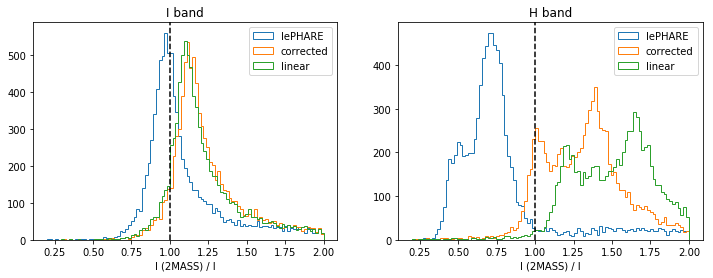

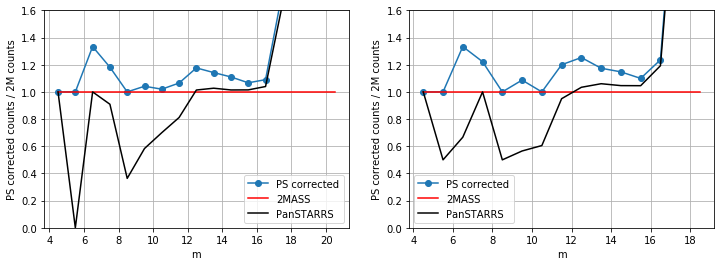

In [32]:
#
catcoorddir='../../doc/20170617_Stacking/maps/catcoord/'
fname=catcoorddir+'PanSTARRS/'+ field + '.csv'
psdf = pd.read_csv(fname)
fname=catcoorddir+'PSC/'+ field + '.csv'
tmdf = pd.read_csv(fname)

fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].hist(10**np.array(-tmdf['I'].iloc[match_idx_tm]/2.5)/10**np.array(-psdf['I_lePH'].iloc[match_idx_ps]/2.5),
           bins=np.linspace(0.2,2,100),histtype='step',fill=False,label='lePHARE')
ax[0].hist(10**np.array(-tmdf['I'].iloc[match_idx_tm]/2.5)/10**np.array(-psdf['I_corr'].iloc[match_idx_ps]/2.5),
           bins=np.linspace(0.2,2,100),histtype='step',fill=False,label='corrected')
ax[0].hist(10**np.array(-tmdf['I'].iloc[match_idx_tm]/2.5)/10**np.array(-psdf['I_lin'].iloc[match_idx_ps]/2.5),
           bins=np.linspace(0.2,2,100),histtype='step',fill=False,label='linear')
ax[0].axvline(1,c='k',ls='--')
ax[0].set_xlabel('I (2MASS) / I')
ax[0].set_title('I band')
ax[0].legend()
ax[1].hist(10**np.array(-tmdf['H'].iloc[match_idx_tm]/2.5)/10**np.array(-psdf['H_lePH'].iloc[match_idx_ps]/2.5),
           bins=np.linspace(0.2,2,100),histtype='step',fill=False,label='lePHARE')
ax[1].hist(10**np.array(-tmdf['H'].iloc[match_idx_tm]/2.5)/10**np.array(-psdf['H_corr'].iloc[match_idx_ps]/2.5),
           bins=np.linspace(0.2,2,100),histtype='step',fill=False,label='corrected')
ax[1].hist(10**np.array(-tmdf['H'].iloc[match_idx_tm]/2.5)/10**np.array(-psdf['H_lin'].iloc[match_idx_ps]/2.5),
           bins=np.linspace(0.2,2,100),histtype='step',fill=False,label='linear')
ax[1].axvline(1,c='k',ls='--')
ax[1].set_xlabel('I (2MASS) / I')
ax[1].set_title('H band')
ax[1].legend()


fig, ax = plt.subplots(1,2,figsize=(12,4))
binedges = np.arange(0,23,1)
bins = (binedges[:-1] + binedges[1:])/2

tmhistall,_ = np.histogram(tmdf['I'], bins = binedges)
tmhist,_ = np.histogram(tmdf['I'][tmdf['ps_match']==0], bins = binedges)
pshist,_ = np.histogram(psdf['I_comb'], bins = binedges)
ax[0].plot(bins,(pshist+tmhist)/tmhistall, 'o-', label = 'PS corrected')
ax[0].plot(bins,tmhistall/tmhistall, 'r-', label = '2MASS')
ax[0].plot(bins,pshist/tmhistall, 'k-', label = 'PanSTARRS')
ax[0].grid()
ax[0].set_ylim([0,1.6])
ax[0].set_xlabel('m')
ax[0].set_ylabel('PS corrected counts / 2M counts')
ax[0].legend(loc=0)

tmhistall,_ = np.histogram(tmdf['H'], bins = binedges)
tmhist,_ = np.histogram(tmdf['H'][tmdf['ps_match']==0], bins = binedges)
pshist,_ = np.histogram(psdf['H_comb'], bins = binedges)
ax[1].plot(bins,(pshist+tmhist)/tmhistall, 'o-', label = 'PS corrected')
ax[1].plot(bins,tmhistall/tmhistall, 'r-', label = '2MASS')
ax[1].plot(bins,pshist/tmhistall, 'k-', label = 'PanSTARRS')
ax[1].grid()
ax[1].set_ylim([0,1.6])
ax[1].set_xlabel('m')
ax[1].set_ylabel('PS corrected counts / 2M counts')
ax[1].legend(loc=0)

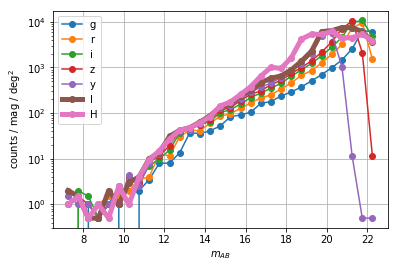

In [33]:
# plot histogram

binedges = np.arange(7,23,0.5)
bins = (binedges[:-1] + binedges[1:])/2
d = psdf['gMeanPSFMag'][(psdf['x1'] > -0.5) & (psdf['y1'] > -0.5) & (psdf['x1'] < 1023.5) & (psdf['y1'] < 1023.5)]
shist,_ = np.histogram(d, bins = binedges)
plt.plot(bins,shist / (binedges[1]-binedges[0]) / 4,'o-',label='g')
d = psdf['rMeanPSFMag'][(psdf['x1'] > -0.5) & (psdf['y1'] > -0.5) & (psdf['x1'] < 1023.5) & (psdf['y1'] < 1023.5)]
shist,_ = np.histogram(d, bins = binedges)
plt.plot(bins,shist / (binedges[1]-binedges[0]) / 4,'o-',label='r')
d = psdf['iMeanPSFMag'][(psdf['x1'] > -0.5) & (psdf['y1'] > -0.5) & (psdf['x1'] < 1023.5) & (psdf['y1'] < 1023.5)]
shist,_ = np.histogram(d, bins = binedges)
plt.plot(bins,shist / (binedges[1]-binedges[0]) / 4,'o-',label='i')
d = psdf['zMeanPSFMag'][(psdf['x1'] > -0.5) & (psdf['y1'] > -0.5) & (psdf['x1'] < 1023.5) & (psdf['y1'] < 1023.5)]
shist,_ = np.histogram(d, bins = binedges)
plt.plot(bins,shist / (binedges[1]-binedges[0]) / 4,'o-',label='z')
d = psdf['yMeanPSFMag'][(psdf['x1'] > -0.5) & (psdf['y1'] > -0.5) & (psdf['x1'] < 1023.5) & (psdf['y1'] < 1023.5)]
shist,_ = np.histogram(d, bins = binedges)
plt.plot(bins,shist / (binedges[1]-binedges[0]) / 4,'o-',label='y')
d = psdf['I_comb'][(psdf['x1'] > -0.5) & (psdf['y1'] > -0.5) & (psdf['x1'] < 1023.5) & (psdf['y1'] < 1023.5)]
shist,_ = np.histogram(d, bins = binedges)
plt.plot(bins,shist / (binedges[1]-binedges[0]) / 4,'o-',lw=5,label='I')
d = psdf['H_comb'][(psdf['x1'] > -0.5) & (psdf['y1'] > -0.5) & (psdf['x1'] < 1023.5) & (psdf['y1'] < 1023.5)]
shist,_ = np.histogram(d, bins = binedges)
plt.plot(bins,shist / (binedges[1]-binedges[0]) / 4,'o-',lw = 5,label='H')

plt.yscale('log')
plt.xlabel('$m_{AB}$')
plt.ylabel('counts / mag / deg$^2$')
plt.legend()
plt.grid()
plt.savefig('ps_counts.png', dpi = 200)

In [1]:
from astropy import units as u
field = 'SWIRE'
catcoorddir='../../doc/20170617_Stacking/maps/catcoord/'
fname=catcoorddir+'PanSTARRS/'+ field + '.csv'
df = pd.read_csv(fname)

In [5]:
df[['gMeanPSFMag','rMeanPSFMag','iMeanPSFMag','zMeanPSFMag','yMeanPSFMag','I_comb','H_comb']].head()

,gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,yMeanPSFMag,I_comb,H_comb
0,20.921301,20.535200,20.329599,20.2873,20.0791,20.1090,19.9750
1,-99.000000,-99.000000,21.900600,-99.0000,-99.0000,21.9006,21.9006
2,-99.000000,21.776699,21.390699,-99.0000,-99.0000,20.8960,20.4280
3,-99.000000,21.956900,21.869699,21.4891,-99.0000,21.2540,20.9010
4,-99.000000,22.637100,-99.000000,-99.0000,-99.0000,22.6371,22.6371


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118336 entries, 0 to 118335
Data columns (total 24 columns):
ra              118336 non-null float64
dec             118336 non-null float64
x1              118336 non-null float64
y1              118336 non-null float64
x2              118336 non-null float64
y2              118336 non-null float64
gMeanPSFMag     118336 non-null float64
rMeanPSFMag     118336 non-null float64
iMeanPSFMag     118336 non-null float64
zMeanPSFMag     118336 non-null float64
yMeanPSFMag     118336 non-null float64
dbscanClass     118336 non-null float64
sdssClass       118336 non-null float64
Photz           118336 non-null float64
PhotzErr        118336 non-null float64
I_lin           118336 non-null float64
H_lin           118336 non-null float64
I_corr          118336 non-null float64
H_corr          118336 non-null float64
lePHAREClass    118336 non-null int64
I_lePH          118336 non-null float64
H_lePH          118336 non-null float64
I_comb     

# plot z kernel of stacked sources

In [37]:
from astropy import units as u
field = 'SWIRE'
catcoorddir='../../doc/20170617_Stacking/maps/catcoord/'
fname=catcoorddir+'PanSTARRS/'+ field + '.csv'
df = pd.read_csv(fname)

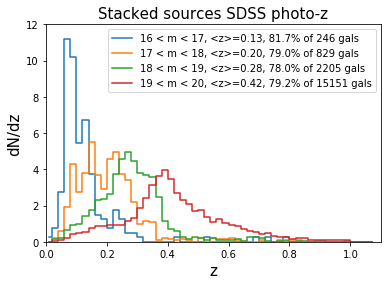

In [38]:
binedges = np.arange(0,1.1,0.02)
bins = (binedges[1:] + binedges[:-1]) / 2

for im in range(4):
    m_min = im + 16
    m_max = im + 17
    z = np.array(df['Photz'].loc[(df['sdssClass']==3) \
                                 &(df['I_comb']>m_min)&(df['I_comb']<m_max)])
    f = len(z[z>=0])/len(z)
    meanz = np.mean(z[z>=0])
    h,_ = np.histogram(z[z>=0], bins=binedges, density=True)
    plt.step(bins,h, where='mid', 
             label='%d < m < %d, <z>=%.2f, %.1f%% of %d gals'%(m_min,m_max,meanz,f*100,len(z)))

plt.xlabel('z', fontsize=15)
plt.ylabel('dN/dz', fontsize=15)
plt.title('Stacked sources SDSS photo-z', fontsize=15)
plt.ylim([0,12])
plt.xlim([0,1.1])
plt.legend()
plt.savefig('z_kernel.png', dpi = 150,bbox_inches='tight')

# plot MRR cat

In [39]:
from scipy.io import loadmat
cat = loadmat('/Users/ytcheng/ciber/doc/20170617_Stacking/maps/mrrcats/mrr_cat_SWIRE.mat')

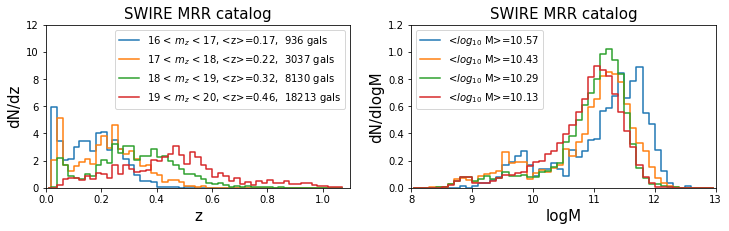

In [40]:
ra = cat['cat']['ra'][0][0][:,0]
dec = cat['cat']['dec'][0][0][:,0]
z = 10**cat['cat']['z'][0][0][:,0]-1
mass = cat['cat']['mass'][0][0][:,0]
zm = cat['cat']['zm'][0][0][:,0]
mst = cat['cat']['mst'][0][0][:,0]

fig, ax = plt.subplots(1,2, figsize=(12,3))
zbinedges = np.arange(0,1.1,0.02)
zbins = (zbinedges[1:] + zbinedges[:-1]) / 2
mbinedges = np.arange(8,13.02,0.1)
mbins = (mbinedges[1:] + mbinedges[:-1]) / 2
for im in range(4):
    m_min = im + 16
    m_max = im + 17
    zi = z[(zm > m_min) & (zm < m_max) & (mst > 0)]
    massi = mass[(zm > m_min) & (zm < m_max) & (mst > 0)]
    meanz = np.mean(zi)
    meanmass = np.mean(massi)
    h,_ = np.histogram(zi, bins=zbinedges, density=True)
    ax[0].step(zbins,h, where='mid', 
             label='%d < $m_z$ < %d, <z>=%.2f,  %d gals'%(m_min,m_max,meanz,len(zi)))
    h,_ = np.histogram(massi, bins=mbinedges, density=True)
    ax[1].step(mbins,h, where='mid', 
             label='<$log_{10}$ M>=%.2f'%meanmass)

ax[0].set_xlabel('z', fontsize=15)
ax[0].set_ylabel('dN/dz', fontsize=15)
ax[0].set_title('SWIRE MRR catalog', fontsize=15)
ax[0].set_ylim([0,12])
ax[0].set_xlim([0,1.1])
ax[0].legend()

ax[1].set_xlabel('logM', fontsize=15)
ax[1].set_ylabel('dN/dlogM', fontsize=15)
ax[1].set_title('SWIRE MRR catalog', fontsize=15)
ax[1].set_ylim([0,1.2])
ax[1].set_xlim([8,13])
ax[1].legend()

plt.savefig('MRR.png', dpi = 150, bbox_inches='tight')